# Chapter 4: Syntactic Sugar and Computing Every Function

This notebook contains code related to **Chapter 4: Syntactic Sugar and Computing Every Function**.

In [1]:
# utility code 
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

In [2]:
import re
def desugar(code, func_name, func_args,func_body):
    """
    Replaces all occurences of 
       foo = func_name(func_args) 
    with
       func_body[x->a,y->b]
       foo = [result returned in func_body]    
    """
    # [Following the theme of separating specification of function from its implementation,
    # want to use the docstring for the specification only, and in-function comments to describe
    # implementation.]"""Use `search and replace' to replace calls to a function with its code.
    
    # Uses Python regular expressions to simplify the search and replace,
    # see https://docs.python.org/3/library/re.html
    
    # regular expression for capturing a list of variable names separated by commas
    arglist = ",".join([r"([a-zA-Z0-9\_\[\]]+)" for i in range(len(func_args))])
    # regular expression for capturing a statement of the form
    # "variable = func_name(arguments)"
    regexp = fr'([a-zA-Z0-9\_\[\]]+)\s*=\s*{func_name}\({arglist}\)\s*$'
    
    while True:
        m = re.search(regexp, code, re.MULTILINE)
        if not m: break

        newcode = func_body 

        # replace function arguments by the variables from the function invocation
        for i in range(len(func_args)): 
            newcode = newcode.replace(func_args[i], m.group(i+2))
        
        # Splice the new code inside
        newcode = newcode.replace('return', m.group(1) + " = ")
        code = code[:m.start()] + newcode + code[m.end()+1:]

    return code

In [16]:
blah =  r'''temp = NAND(a,b)
return NAND(b,c)
'''

code = r'''
z = blah(x,y)
w = blah(z,x)
'''

print(desugar(code,"blah",['a','b'],blah))


temp = NAND(x,y)
z =  NAND(y,c)
temp = NAND(z,x)
w =  NAND(x,c)



In [17]:
def parse_func(code):
    """Parse a function definition into name, arguments and body"""
    lines = [l.strip() for l in code.split('\n')]
    regexp = r'def\s+([a-zA-Z\_0-9]+)\(([\sa-zA-Z0-9\_,]+)\)\s*:\s*'
    m = re.match(regexp,lines[0])
    return m.group(1), m.group(2).split(','), '\n'.join(lines[1:])

## Some examples

In [18]:
notfunc = parse_func('''def NOT(a): 
    return NAND(a,a)
''')

andfunc = parse_func('''def AND(a,b):
    temp = NAND(a,b) 
    return NOT(temp)
''')

orfunc = parse_func('''def OR(a,b):
    temp1 = NOT(a)
    temp2 = NOT(b) 
    return NAND(temp1,temp2)
''')


majcode= '''and1 = AND(X[0],X[1])
and2 = AND(X[0],X[2])
and3 = AND(X[1],X[2])
or1  = OR(and1,and2)
Y[0] = OR(or1,and3)
'''

In [19]:
tmp = desugar(majcode,*orfunc)
print(tmp)

and1 = AND(X[0],X[1])
and2 = AND(X[0],X[2])
and3 = AND(X[1],X[2])
temp1 = NOT(and1)
temp2 = NOT(and2)
or1 =  NAND(temp1,temp2)
temp1 = NOT(or1)
temp2 = NOT(and3)
Y[0] =  NAND(temp1,temp2)



In [20]:
tmp = desugar(tmp,*andfunc)
print(tmp)

temp = NAND(X[0],X[1])
and1 =  NOT(temp)
temp = NAND(X[0],X[2])
and2 =  NOT(temp)
temp = NAND(X[1],X[2])
and3 =  NOT(temp)
temp1 = NOT(and1)
temp2 = NOT(and2)
or1 =  NAND(temp1,temp2)
temp1 = NOT(or1)
temp2 = NOT(and3)
Y[0] =  NAND(temp1,temp2)



In [21]:
tmp = desugar(tmp,*notfunc)
print(tmp)

temp = NAND(X[0],X[1])
and1 =  NAND(temp,temp)
temp = NAND(X[0],X[2])
and2 =  NAND(temp,temp)
temp = NAND(X[1],X[2])
and3 =  NAND(temp,temp)
temp1 =  NAND(and1,and1)
temp2 =  NAND(and2,and2)
or1 =  NAND(temp1,temp2)
temp1 =  NAND(or1,or1)
temp2 =  NAND(and3,and3)
Y[0] =  NAND(temp1,temp2)



In [22]:
C = prog2circuit(tmp)
schemdraw(C)

NameError: name 'prog2circuit' is not defined

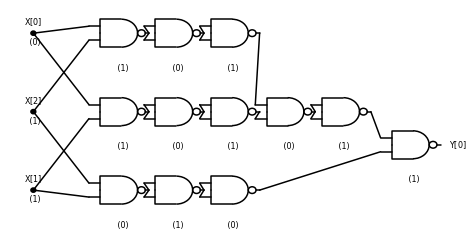

In [10]:
schemdraw(C,[0,1,1])

In [23]:
majsmaller = r'''temp = NAND(X[0],X[1])
temp2 = NAND(X[0],X[2])
temp3 = NAND(X[1],X[2])
or1 =  NAND(temp,temp2)
temp1 =  NAND(or1,or1)
Y[0] =  NAND(temp1,temp3)
'''

In [24]:
C = prog2circuit(majsmaller)
schemdraw(C)

NameError: name 'prog2circuit' is not defined

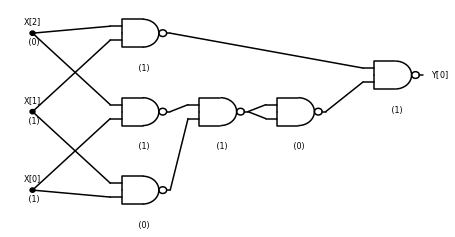

In [13]:
schemdraw(C,[1,1,0])

## More sugar

Removing function calls that are used as sub-expressions can be done as follows

In [25]:
def desugar2(code, func_name, func_args, func_body):
    """De-sugaring of functions calls that are used as expressions inside other calls.
    We create a temporary variable to store the results of such expressions."""
    code = desugar(code,func_name,func_args,func_body)
    arglist = ",".join([r"([a-zA-Z0-9\_]+)" for i in range(len(func_args))])
    regexp = fr'[\s=\(\,]{func_name}\({arglist}\)\s*'
    counter = 0
    while True:
        m = re.search(regexp,code)
        if not m: break
        
        newcode = func_body
        for i in range(len(func_args)):
            newcode = newcode.replace(func_args[i],m.group(i+1))
        newvar = f'temp_unique_{counter}'
        counter += 1
        newcode = newcode.replace('return', newvar + " = ")
        i = code.rfind('\n',0,m.start())
        code = code[:i+1]+ newcode + code[i+1:m.start()+1] + newvar + code[m.end():]
    
    return code

In [26]:
andfunc = r'''def AND(a,b):
   temp = NAND(a,b)
   return NAND(temp,temp)
'''

parse_func(andfunc)

('AND', ['a', 'b'], 'temp = NAND(a,b)\nreturn NAND(temp,temp)\n')

In [27]:
code =  r'''blah = AND(x,y)'''
desugar(code,*parse_func(andfunc))

'temp = NAND(x,y)\nblah =  NAND(temp,temp)\n'

In [28]:
nandfunc = r'''def NAND(a,b):
temp = NAND(a,b)
return temp'''

parse_func(nandfunc)

('NAND', ['a', 'b'], 'temp = NAND(a,b)\nreturn temp')

In [31]:
print(desugar2('blah = AND(AND(x,y),AND(z,w))',*parse_func(andfunc)))

temp = NAND(x,y)
temp_unique_0 =  NAND(temp,temp)
temp = NAND(z,w)
temp_unique_1 =  NAND(temp,temp)
temp = NAND(temp_unique_0,temp_unique_1)
temp_unique_2 =  NAND(temp,temp)
blah = temp_unique_2


# Even more sugar

We could implement all our syntactic sugar constructs as "search and replace" but it is easier for us to "piggy back" on top of Python and use it to "de-sugar" our programs.

The idea is that we can use "symbolic execution" and redefine `NAND()` to simply print out the NAND-CIRC code  instead computing the NAND operation. This is best illustrated by an example.

In [19]:
counter = 0
def NAND(a,b):
    global counter
    counter += 1
    v = f'temp_{counter}'
    print(f'{v} = NAND({a},{b})')
    return v

In [20]:
def NOT(a): 
    return NAND(a,a)
def AND(a,b):
    temp = NAND(a,b) 
    return NOT(temp)
def OR(a,b):
    temp1 = NOT(a)
    temp2 = NOT(b) 
    return NAND(temp1,temp2)

def MAJ(a,b,c):
    and1 = AND(a,b)
    and2 = AND(a,c)
    and3 = AND(b,c)
    or1 = OR(and1,and2)
    return OR(or1,and3)

MAJ('X[0]','X[1]','X[1]')

temp_1 = NAND(X[0],X[1])
temp_2 = NAND(temp_1,temp_1)
temp_3 = NAND(X[0],X[1])
temp_4 = NAND(temp_3,temp_3)
temp_5 = NAND(X[1],X[1])
temp_6 = NAND(temp_5,temp_5)
temp_7 = NAND(temp_2,temp_2)
temp_8 = NAND(temp_4,temp_4)
temp_9 = NAND(temp_7,temp_8)
temp_10 = NAND(temp_9,temp_9)
temp_11 = NAND(temp_6,temp_6)
temp_12 = NAND(temp_10,temp_11)


'temp_12'

Notice that this is a NAND-CIRC program to compute MAJ - we just have to replace `temp_19` with `Y[0]`. 

If we redefine `NAND` to its usual value, then we can use the same code to compute $MAJ$:

In [21]:
def NAND(a,b): return 1-a*b

MAJ(1,0,1)

1